In [133]:
#Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features.

In [134]:
!pip install imblearn

In [135]:
import imblearn
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
password = getpass.getpass()

········


In [164]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

query = '''
select f.film_id, f.title, f.rental_duration, f.rental_rate, count(r.rental_id), f.length, f.rating
from sakila.film f
join sakila.inventory i 
on f.film_id= i.film_id
join sakila.rental r
on i.inventory_id= r.inventory_id
group by f.film_id

                '''

data = pd.read_sql_query(query, engine)
data

,film_id,title,rental_duration,rental_rate,count(r.rental_id),length,rating
0,1,ACADEMY DINOSAUR,6,0.99,23,86,PG
1,2,ACE GOLDFINGER,3,4.99,7,48,G
2,3,ADAPTATION HOLES,7,2.99,12,50,NC-17
3,4,AFFAIR PREJUDICE,5,2.99,23,117,G
4,5,AFRICAN EGG,6,2.99,12,130,G
...,...,...,...,...,...,...,...
953,996,YOUNG LANGUAGE,6,0.99,7,183,G
954,997,YOUTH KICK,4,0.99,6,179,NC-17
955,998,ZHIVAGO CORE,6,0.99,9,105,NC-17
956,999,ZOOLANDER FICTION,5,2.99,17,101,R


In [165]:
#Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [166]:
data.shape

(958, 7)

In [167]:
data.describe()

,film_id,rental_duration,rental_rate,count(r.rental_id),length
count,958.000000,958.000000,958.000000,958.000000,958.000000
mean,502.598121,4.969729,2.977474,16.747390,115.490605
std,287.541738,1.407593,1.643152,6.676185,40.471844
min,1.000000,3.000000,0.990000,4.000000,46.000000
25%,256.250000,4.000000,0.990000,11.000000,80.250000
50%,504.500000,5.000000,2.990000,16.000000,114.000000
75%,751.750000,6.000000,4.990000,22.000000,150.000000
max,1000.000000,7.000000,4.990000,34.000000,185.000000


In [168]:
data.isna().sum()

film_id               0
title                 0
rental_duration       0
rental_rate           0
count(r.rental_id)    0
length                0
rating                0
dtype: int64

In [169]:
# We don't have any Nans

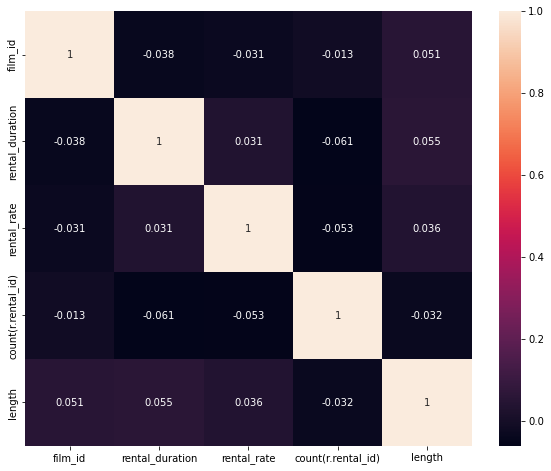

In [170]:
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [171]:
# We don't have too much high correlation between variables 

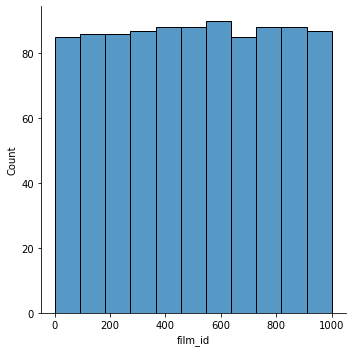

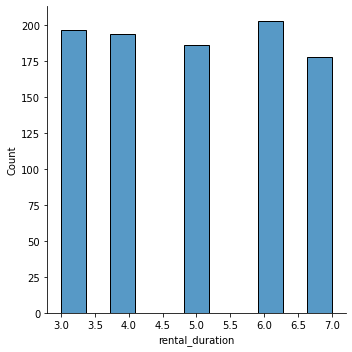

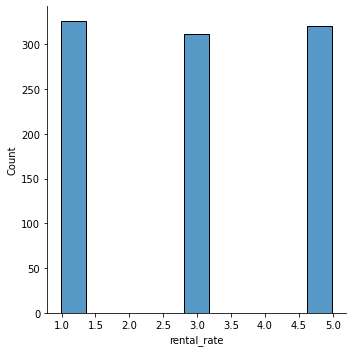

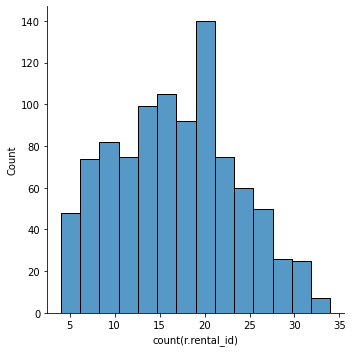

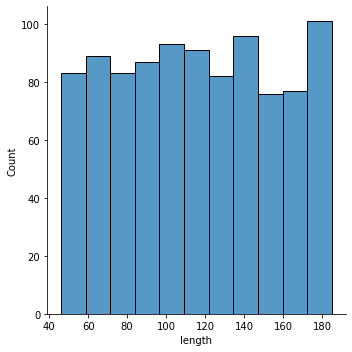

In [172]:
for col in data.select_dtypes(np.number):
    sns.displot(data[col])
    plt.show() # some plots to understand the distribution of the variables

In [173]:
# Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.

In [174]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

query = '''
select f.film_id, title, r.rental_date
from sakila.film f
join sakila.inventory i 
on f.film_id= i.film_id
join sakila.rental r
on i.inventory_id= r.inventory_id


                '''

target_variable = pd.read_sql_query(query, engine)
target_variable

,film_id,title,rental_date
0,1,ACADEMY DINOSAUR,2005-07-08 19:03:15
1,1,ACADEMY DINOSAUR,2005-08-02 20:13:10
2,1,ACADEMY DINOSAUR,2005-08-21 21:27:43
3,1,ACADEMY DINOSAUR,2005-05-30 20:21:07
4,1,ACADEMY DINOSAUR,2005-06-17 20:24:00
...,...,...,...
16039,1000,ZORRO ARK,2005-05-29 03:49:03
16040,1000,ZORRO ARK,2005-06-15 21:50:32
16041,1000,ZORRO ARK,2005-07-12 13:24:47
16042,1000,ZORRO ARK,2005-07-31 07:32:21


In [175]:
target_variable

,film_id,title,rental_date
0,1,ACADEMY DINOSAUR,2005-07-08 19:03:15
1,1,ACADEMY DINOSAUR,2005-08-02 20:13:10
2,1,ACADEMY DINOSAUR,2005-08-21 21:27:43
3,1,ACADEMY DINOSAUR,2005-05-30 20:21:07
4,1,ACADEMY DINOSAUR,2005-06-17 20:24:00
...,...,...,...
16039,1000,ZORRO ARK,2005-05-29 03:49:03
16040,1000,ZORRO ARK,2005-06-15 21:50:32
16041,1000,ZORRO ARK,2005-07-12 13:24:47
16042,1000,ZORRO ARK,2005-07-31 07:32:21


In [176]:
target_variable['month'] = pd.DatetimeIndex(target_variable['rental_date']).month

In [177]:
target_variable

,film_id,title,rental_date,month
0,1,ACADEMY DINOSAUR,2005-07-08 19:03:15,7
1,1,ACADEMY DINOSAUR,2005-08-02 20:13:10,8
2,1,ACADEMY DINOSAUR,2005-08-21 21:27:43,8
3,1,ACADEMY DINOSAUR,2005-05-30 20:21:07,5
4,1,ACADEMY DINOSAUR,2005-06-17 20:24:00,6
...,...,...,...,...
16039,1000,ZORRO ARK,2005-05-29 03:49:03,5
16040,1000,ZORRO ARK,2005-06-15 21:50:32,6
16041,1000,ZORRO ARK,2005-07-12 13:24:47,7
16042,1000,ZORRO ARK,2005-07-31 07:32:21,7


In [178]:
target_variable['Rented_or_not'] = np.where(target_variable['month'] == 8, 1, 0)

In [179]:
target_variable

,film_id,title,rental_date,month,Rented_or_not
0,1,ACADEMY DINOSAUR,2005-07-08 19:03:15,7,0
1,1,ACADEMY DINOSAUR,2005-08-02 20:13:10,8,1
2,1,ACADEMY DINOSAUR,2005-08-21 21:27:43,8,1
3,1,ACADEMY DINOSAUR,2005-05-30 20:21:07,5,0
4,1,ACADEMY DINOSAUR,2005-06-17 20:24:00,6,0
...,...,...,...,...,...
16039,1000,ZORRO ARK,2005-05-29 03:49:03,5,0
16040,1000,ZORRO ARK,2005-06-15 21:50:32,6,0
16041,1000,ZORRO ARK,2005-07-12 13:24:47,7,0
16042,1000,ZORRO ARK,2005-07-31 07:32:21,7,0


In [180]:
# Create a logistic regression model to predict this variable from the cleaned data.

In [181]:
target_variable = target_variable.drop('rental_date', axis=1)

In [182]:
target_variable

,film_id,title,month,Rented_or_not
0,1,ACADEMY DINOSAUR,7,0
1,1,ACADEMY DINOSAUR,8,1
2,1,ACADEMY DINOSAUR,8,1
3,1,ACADEMY DINOSAUR,5,0
4,1,ACADEMY DINOSAUR,6,0
...,...,...,...,...
16039,1000,ZORRO ARK,5,0
16040,1000,ZORRO ARK,6,0
16041,1000,ZORRO ARK,7,0
16042,1000,ZORRO ARK,7,0


In [183]:
target_variable = target_variable.drop('title', axis=1)

In [184]:
data2 = pd.merge(data, target_variable)
data2

,film_id,title,rental_duration,rental_rate,count(r.rental_id),length,rating,month,Rented_or_not
0,1,ACADEMY DINOSAUR,6,0.99,23,86,PG,7,0
1,1,ACADEMY DINOSAUR,6,0.99,23,86,PG,8,1
2,1,ACADEMY DINOSAUR,6,0.99,23,86,PG,8,1
3,1,ACADEMY DINOSAUR,6,0.99,23,86,PG,5,0
4,1,ACADEMY DINOSAUR,6,0.99,23,86,PG,6,0
...,...,...,...,...,...,...,...,...,...
16039,1000,ZORRO ARK,3,4.99,31,50,NC-17,5,0
16040,1000,ZORRO ARK,3,4.99,31,50,NC-17,6,0
16041,1000,ZORRO ARK,3,4.99,31,50,NC-17,7,0
16042,1000,ZORRO ARK,3,4.99,31,50,NC-17,7,0


In [185]:
data3=data2

In [186]:
data3

,film_id,title,rental_duration,rental_rate,count(r.rental_id),length,rating,month,Rented_or_not
0,1,ACADEMY DINOSAUR,6,0.99,23,86,PG,7,0
1,1,ACADEMY DINOSAUR,6,0.99,23,86,PG,8,1
2,1,ACADEMY DINOSAUR,6,0.99,23,86,PG,8,1
3,1,ACADEMY DINOSAUR,6,0.99,23,86,PG,5,0
4,1,ACADEMY DINOSAUR,6,0.99,23,86,PG,6,0
...,...,...,...,...,...,...,...,...,...
16039,1000,ZORRO ARK,3,4.99,31,50,NC-17,5,0
16040,1000,ZORRO ARK,3,4.99,31,50,NC-17,6,0
16041,1000,ZORRO ARK,3,4.99,31,50,NC-17,7,0
16042,1000,ZORRO ARK,3,4.99,31,50,NC-17,7,0


In [187]:
data2.dtypes

film_id                 int64
title                  object
rental_duration         int64
rental_rate           float64
count(r.rental_id)      int64
length                  int64
rating                 object
month                   int64
Rented_or_not           int64
dtype: object

In [188]:
data2 = data2.drop('title', axis=1)

In [189]:
X = pd.get_dummies(data2.drop('Rented_or_not', axis=1))
y = data2['Rented_or_not']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_train, y_train)

predictions = classification.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2072
           1       1.00      1.00      1.00      1137

    accuracy                           1.00      3209
   macro avg       1.00      1.00      1.00      3209
weighted avg       1.00      1.00      1.00      3209



In [ ]:
# I something is wrong, the model is not capable to predict if a film is rented or not. The values of precision, recall and accurancy doesn't really make sense.

In [ ]:
# I will try to do a boxcox transformation to see if my model can improve. 

In [190]:
data2

,film_id,rental_duration,rental_rate,count(r.rental_id),length,rating,month,Rented_or_not
0,1,6,0.99,23,86,PG,7,0
1,1,6,0.99,23,86,PG,8,1
2,1,6,0.99,23,86,PG,8,1
3,1,6,0.99,23,86,PG,5,0
4,1,6,0.99,23,86,PG,6,0
...,...,...,...,...,...,...,...,...
16039,1000,3,4.99,31,50,NC-17,5,0
16040,1000,3,4.99,31,50,NC-17,6,0
16041,1000,3,4.99,31,50,NC-17,7,0
16042,1000,3,4.99,31,50,NC-17,7,0


In [191]:
from scipy import stats


def boxcox_transform(data2):
    numeric_cols = data2.select_dtypes(np.number).columns
    _ci = {column: None for column in numeric_cols}
    for column in numeric_cols:
 
        data2[column] = np.where(data2[column]<=0, np.NAN, data2[column]) 
        data2[column] = data2[column].fillna(data2[column].mean())
        transformed_data, ci = stats.boxcox(data2[column])
        data2[column] = transformed_data
        _ci[column] = [ci] 
    return data2, _ci

data2, _ci = boxcox_transform(data)
data2

,film_id,title,rental_duration,rental_rate,count(r.rental_id),length,rating
0,0.000000,ACADEMY DINOSAUR,3.492486,-0.010024,9.894869,31.952568,PG
1,0.898109,ACE GOLDFINGER,1.630786,2.530046,3.829705,20.633402,G
2,1.672123,ADAPTATION HOLES,4.039329,1.482394,6.025942,21.282248,NC-17
3,2.375165,AFFAIR PREJUDICE,2.915258,1.482394,9.894869,40.111140,G
4,3.029745,AFRICAN EGG,3.492486,1.482394,6.025942,43.339569,G
...,...,...,...,...,...,...,...
953,196.328612,YOUNG LANGUAGE,3.492486,-0.010024,3.829705,55.650231,G
954,196.471079,YOUTH KICK,2.299235,-0.010024,3.327363,54.760996,NC-17
955,196.613505,ZHIVAGO CORE,3.492486,-0.010024,4.761229,37.037603,NC-17
956,196.755891,ZOOLANDER FICTION,2.915258,1.482394,7.899166,35.990848,R


In [196]:
extracted_col = data3["Rented_or_not"]

In [197]:
data2 = data2.join(extracted_col)

In [198]:
data2

,film_id,title,rental_duration,rental_rate,count(r.rental_id),length,rating,Rented_or_not
0,0.000000,ACADEMY DINOSAUR,3.492486,-0.010024,9.894869,31.952568,PG,0
1,0.898109,ACE GOLDFINGER,1.630786,2.530046,3.829705,20.633402,G,1
2,1.672123,ADAPTATION HOLES,4.039329,1.482394,6.025942,21.282248,NC-17,1
3,2.375165,AFFAIR PREJUDICE,2.915258,1.482394,9.894869,40.111140,G,0
4,3.029745,AFRICAN EGG,3.492486,1.482394,6.025942,43.339569,G,0
...,...,...,...,...,...,...,...,...
953,196.328612,YOUNG LANGUAGE,3.492486,-0.010024,3.829705,55.650231,G,0
954,196.471079,YOUTH KICK,2.299235,-0.010024,3.327363,54.760996,NC-17,1
955,196.613505,ZHIVAGO CORE,3.492486,-0.010024,4.761229,37.037603,NC-17,0
956,196.755891,ZOOLANDER FICTION,2.915258,1.482394,7.899166,35.990848,R,0


In [200]:
X = pd.get_dummies(data2.drop('Rented_or_not', axis=1))
y = data2['Rented_or_not']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

classification = LogisticRegression(random_state=42, max_iter=100000)
classification.fit(X_train, y_train)

predictions = classification.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.64      0.99      0.78       124
           1       0.00      0.00      0.00        68

    accuracy                           0.64       192
   macro avg       0.32      0.50      0.39       192
weighted avg       0.42      0.64      0.50       192



In [201]:
# Now the values have a little more sense, even though they don't really give me confidence about giving good predictions.

In [202]:
# We see that the presicion of 0 (not rented) is 0,64, thise tells us that from all the values that were predicted 0, wich 64% where actually 0. 

In [203]:
# The model is not capable to predict the 1's (rented)

In [204]:
# We have and accuracy of 0,64 which tells us that from everything how many we got right, mainly 0's. 

In [205]:
# With this recall we can guess the model is good at predicting 0, but not 1's

In [206]:
# Probably the model does not have enough variables and lacks information